In [7]:
!git clone https://github.com/quinn-parker/polymer-ML-research.git
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import keras
from sklearn.manifold import MDS
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
import matplotlib
%matplotlib inline
from sklearn.preprocessing import scale # This is for Data scaling
from sklearn import decomposition #AKA: PCA
from sklearn.metrics import confusion_matrix
import plotly.express as px # for graphing in the PCA section


print('Done')

fatal: destination path 'polymer-ML-research' already exists and is not an empty directory.
Done


# 1. Supervised learning on coordinates

In [ ]:
##This data frame is concat from 100 row element files (127 files in total). Each monomer structure is created by 100 rows, each with three coordinates.

##Clunky, but he we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/normal coordinates/b-config.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/normal coordinates/c-config.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/normal coordinates/ge-config.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/normal coordinates/gi-config.csv', header=None)
rData = pd.read_csv('/content/polymer-ML-research/normal coordinates/r-config.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)
rAnswers = pd.read_csv('/content/polymer-ML-research/Answers/r-labels.csv', header=None)

##Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData, rData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers, rAnswers])

##Using SKlearn for splitting test and training into 33% testing and the rest for training.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(totalData, totalAnswers, test_size=0.33, random_state=34234)

In [ ]:
#from sklearn.model_selection import StratifiedKFold
#seed = 1701
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
#cvscores = []
#for train, test in kfold.split(totalData, totalAnswers):


  ## Here we initiate the keras sequential api and use dense layers.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
np.random.seed(1701)
model = Sequential()
model.add(Dense(units =100, activation = 'relu', input_shape = totalData.shape[1:]))
model.add(Dense(units = 100, activation='relu', kernel_regularizer=keras.regularizers.l2(0.03)))
model.add(Dropout(0.20))
model.add(Dense(units = 5, activation = 'softmax', kernel_regularizer=keras.regularizers.l2(0.02)))
  #kernel_initializer='uniform'

import math
  #initial_lrate = 1
  #drop = 0.1
  #epochs_drop = 60.0
  #lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  #opt = keras.optimizers.rmsprop(lr=lrate)
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.99, beta_2=0.99, epsilon=1e-07, name="Nadam"), loss =keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=500,batch_size=30, validation_data=(X_test,y_test))

  #scores = model.evaluate(X_test, y_test, verbose=0)
 # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#cvscores.append(scores[1] * 100)
#print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [ ]:


#from sklearn import svm
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#from sklearn.model_selection import cross_val_score

#scores = cross_val_score(history, totalData, totalAnswers, cv=5)


#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(history, totalData, totalAnswers, cv=5)

In [ ]:
#In case you need to clear the previous action, easily.
%reset

Confusion matrix, without normalization
[[78  0  5  0  0]
 [ 0 55 14 15  2]
 [ 1 14 54  1  0]
 [ 0  9  3 90  0]
 [ 0  3  2  3 69]]
Normalized confusion matrix
[[0.94 0.   0.06 0.   0.  ]
 [0.   0.64 0.16 0.17 0.02]
 [0.01 0.2  0.77 0.01 0.  ]
 [0.   0.09 0.03 0.88 0.  ]
 [0.   0.04 0.03 0.04 0.9 ]]


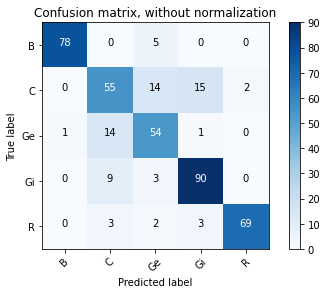

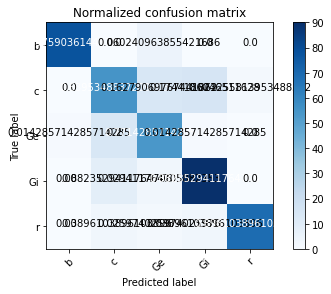

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##Lets make a confusing Confusion Matrix with SKLearn.
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test)
classes_pred = np.argmax(pred, axis = 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, classes_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
nonNormalMatrix = plot_confusion_matrix(cnf_matrix, classes=['B','C','Ge','Gi','R'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
normalMatrix = plot_confusion_matrix(cnf_matrix, classes=['b','c','Ge','Gi','r'], normalize=True, title='Normalized confusion matrix')
normalMatrix

In [ ]:
##We now print a classification report from confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        83
           1       0.68      0.64      0.66        86
           2       0.69      0.77      0.73        70
           3       0.83      0.88      0.85       102
           4       0.97      0.90      0.93        77

    accuracy                           0.83       418
   macro avg       0.83      0.83      0.83       418
weighted avg       0.83      0.83      0.83       418



<Figure size 432x288 with 0 Axes>

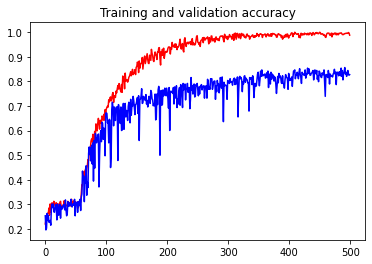

<Figure size 432x288 with 0 Axes>

In [ ]:
## Now we can do a little plot to see the correlation between the training statistics and the validation statistics. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))



plt.plot(epochs, acc, 'r', label='Training accuracy')
plt. plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()




In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
classifier.save('/content/monomer-new-data/myModel3') 

In [ ]:
## For sake of curiosity, let us run a few variations on our fit function to see if there are any values which optimize accuracy, and waste
##some computing power.

#batch is the starting batch size for the fit function
#n is what the highest batch will reach.

#from keras.models import Sequential
#from keras.layers import Dense
#model = Sequential() 
#model.add(Dense(units =100, activation = 'relu', input_shape = totalData.shape[1:]))
#model.add(Dense(units = 50, activation='relu'))
#model.add(Dense(units = 5, activation = 'softmax'))


#model.compile(optimizer='rmsprop', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

#batch = 1
#n = 100
#while batch <= n:
# history = model.fit(X_train, y_train, batch_size = batch, epochs=150, validation_data=(X_test,y_test))
# batch = batch + 1

In [ ]:
# Scale data
from sklearn.preprocessing import StandardScaler

scaled = StandardScaler()
scaled.fit(X_train)

X_train_scaled = scaled.transform(X_train)
X_test_scaled = scaled.transform(X_test)

In [ ]:
## Here we initiate the keras sequential api and use dense layers. The final layer will output with softmax.
from keras.models import Sequential
from keras.layers import Dense
np.random.seed(1701)
classifierScaled = Sequential() 
classifierScaled.add(Dense(units =100, activation = 'relu', input_shape = totalData.shape[1:]))
classifierScaled.add(Dense(units = 50, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)))
classifierScaled.add(Dropout(0.10))
classifierScaled.add(Dense(units = 5, activation = 'softmax', kernel_regularizer=keras.regularizers.l2(0.02)))

In [ ]:
import math
#epoch = 1000
#initial_lrate = 1
#drop = 0.1
#epochs_drop = 60.0
#lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))

#opt = keras.optimizers.rmsprop(lr=lrate)

loss_fn = keras.losses.SparseCategoricalCrossentropy()

classifierScaled.compile(optimizer='rmsprop', loss =loss_fn, metrics=['accuracy'])

In [ ]:
 history = classifierScaled.fit(X_train, y_train, epochs=550,batch_size=30, validation_data=(X_test,y_test))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
##Lets make a confusing Confusion Matrix with SKLearn.
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pred = classifierScaled.predict(X_test)
classes_pred = np.argmax(pred, axis = 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, classes_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
nonNormalMatrix = plot_confusion_matrix(cnf_matrix, classes=['B','C','Ge','Gi','R'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
normalMatrix = plot_confusion_matrix(cnf_matrix, classes=['b','c','Ge','Gi','r'], normalize=True, title='Normalized confusion matrix')
normalMatrix

In [ ]:
##We now print a classification report from confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_pred))

In [ ]:
## Now we can do a little plot to see the correlation between the training statistics and the validation statistics. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))



plt.plot(epochs, acc, 'r', label='Training accuracy')
plt. plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()

# 2. PCA with our raw monomer coordinates

In [ ]:
## We need to scale this data accordingly.
#data = scale(totalData)
data = totalData

In [ ]:
## We can now perform a PCA decomposition down to about 10 components.
pca = decomposition.PCA(n_components=10)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
scores = pca.transform(data)

In [ ]:
## Put the scores into a readable dataframe. All the components will be shown.
scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])


##Lets append the labels on the PCA dataframe. $$$ B = 0 C = 1 Ge = 2 Gi = 3 $$$
df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df
scoresDataframe

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,labels
0,122.087057,-7.693849,-3.531797,56.405247,6.198136,-1.360118,-0.104223,-3.198025,-0.009757,0.471593,0
1,828.384618,-12.915950,-3.839597,-15.811024,-41.551850,7.880756,2.154001,-8.048106,1.938541,-0.179558,0
2,1769.015551,-18.034687,-3.616586,-37.427305,-12.806052,1.194283,4.096574,-17.483492,1.117969,-2.087097,0
3,2145.988283,-20.223510,-3.437830,39.996087,-1.753099,-0.702664,1.509183,-7.552374,-2.125123,-0.154356,0
4,-174.859285,-6.651929,-3.261719,45.630498,3.405383,-0.231458,-1.253835,1.916820,-1.596438,-0.470761,0
...,...,...,...,...,...,...,...,...,...,...,...
1261,1401.669647,-46.429838,10.854103,4.964112,47.110246,-0.180975,1.862837,-0.486490,0.575788,1.876107,4
1262,-2243.022482,-43.136973,14.929760,14.204760,19.215604,-19.057977,-1.855190,3.846102,-15.889075,4.960146,4
1263,1101.366360,-23.499711,-2.806098,7.596957,-32.480574,10.408333,31.658905,-3.119687,2.235231,-5.597613,4
1264,-679.157042,-38.567176,9.197091,18.285605,-20.265284,1.477760,25.343710,-4.106929,8.067773,-8.119052,4


In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

In [ ]:
pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)
pcaCombinedDf

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000000
1,PC1,0.951035,0.951035
2,PC2,0.029059,0.980094
3,PC3,0.019299,0.999393
4,PC4,0.000235,0.999628
5,PC5,0.000057,0.999685
6,PC6,0.000038,0.999723
7,PC7,0.000036,0.999759
8,PC8,0.000026,0.999785
9,PC9,0.000020,0.999805


Lets make some plots of the PCA components.


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(scoresDataframe, x='PC1', y='PC2', color='labels')

fig.show()

Lets do the same PCA but with B, C, Ge, Gi only.

In [ ]:
bData = pd.read_csv('/content/polymer-ML-research/normal coordinates/b-config.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/normal coordinates/c-config.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/normal coordinates/ge-config.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/normal coordinates/gi-config.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)

##Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

data = totalData

pca = decomposition.PCA(n_components=10)
pca.fit(data)

scores = pca.transform(data)

scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df

explained_variance = pca.explained_variance_ratio_

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(scoresDataframe, x='PC1', y='PC2', color='labels', title="PCA. This does not include the 'R' type, or scaling.")

fig.show()

# 3. Keras for supervised learning on centre of mass monomer modified coordinates

 Preprocessing modified the coordinates by subtracting the average of all x, y, z from each component.

In [ ]:
##Now we attempt to consider the coordinates with 'centre of mass'.

#Clunky, but here we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/b-config-centre.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/c-config-centre.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/ge-config-centre.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/gi-config-centre.csv', header=None)
rData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/r-config-centre.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)
rAnswers = pd.read_csv('/content/polymer-ML-research/Answers/r-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData, rData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers, rAnswers])

In [ ]:
##Using SKlearn for splitting test and training into 33% testing and the rest for training.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(totalData, totalAnswers, test_size=0.33, random_state=101)

## Here we initiate the keras sequential api and use dense layers. The final layer will output with softmax.
from keras.models import Sequential
from keras.layers import Dense
np.random.seed(1701)
centreMassModel = Sequential() 
centreMassModel.add(Dense(units =100, activation = 'relu', input_shape = totalData.shape[1:]))
centreMassModel.add(Dense(units = 100, activation='relu', kernel_regularizer=keras.regularizers.l2(0.03)))
centreMassModel.add(Dense(units = 5, activation = 'softmax', kernel_regularizer=keras.regularizers.l2(0.02)))

import math
epoch = 550
#initial_lrate = 1
#drop = 0.1
#epochs_drop = 60.0
#lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))

#opt = keras.optimizers.rmsprop(lr=lrate)

loss_fn = keras.losses.SparseCategoricalCrossentropy()

centreMassModel.compile(optimizer='rmsprop', loss =loss_fn, metrics=['accuracy'])

In [ ]:
history = centreMassModel.fit(X_train, y_train, epochs=epoch,batch_size=30, validation_data=(X_test,y_test))

In [ ]:
%reset

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Below we will plot a confusing confusion matrix to show the true postives and negatives for the centre of mass modified monomer files.

Confusion matrix, without normalization
[[89  0  1  0  0]
 [ 1 23 21 31  7]
 [ 1 15 43 12  1]
 [ 1 11 23 56  3]
 [ 2  9  6  6 56]]
Normalized confusion matrix
[[0.99 0.   0.01 0.   0.  ]
 [0.01 0.28 0.25 0.37 0.08]
 [0.01 0.21 0.6  0.17 0.01]
 [0.01 0.12 0.24 0.6  0.03]
 [0.03 0.11 0.08 0.08 0.71]]


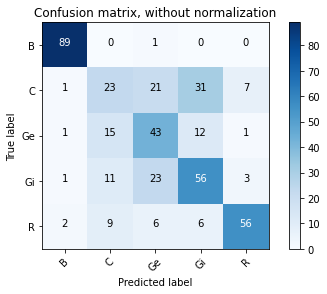

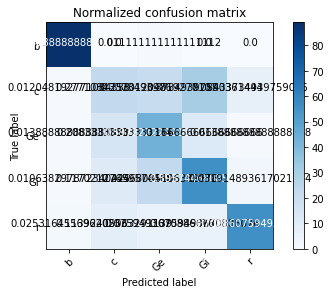

In [ ]:
##Lets make a confusing Confusion Matrix with SKLearn.
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pred = centreMassModel.predict(X_test)
classes_pred = np.argmax(pred, axis = 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, classes_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
nonNormalMatrix = plot_confusion_matrix(cnf_matrix, classes=['B','C','Ge','Gi','R'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
normalMatrix = plot_confusion_matrix(cnf_matrix, classes=['b','c','Ge','Gi','r'], normalize=True, title='Normalized confusion matrix')
normalMatrix

In [ ]:
##We now print a classification report from confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        90
           1       0.40      0.28      0.33        83
           2       0.46      0.60      0.52        72
           3       0.53      0.60      0.56        94
           4       0.84      0.71      0.77        79

    accuracy                           0.64       418
   macro avg       0.63      0.63      0.63       418
weighted avg       0.64      0.64      0.63       418



<Figure size 432x288 with 0 Axes>

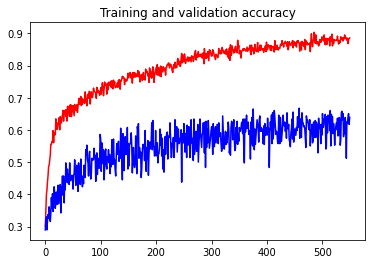

<Figure size 432x288 with 0 Axes>

In [ ]:
## Now we can do a little plot to see the correlation between the training statistics and the validation statistics. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt. plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
classifier.save('/content/monomer-new-data/centre-of-mass-monomer-model') 

Now lets do the same thing, but without R.

In [ ]:
##Now we attempt to consider the coordinates with 'centre of mass'.

#Clunky, but here we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/monomer-new-data/centre-of-mass-monomer-config/b-config-centre.csv', header=None)
cData = pd.read_csv('/content/monomer-new-data/centre-of-mass-monomer-config/c-config-centre.csv', header=None)
geData = pd.read_csv('/content/monomer-new-data/centre-of-mass-monomer-config/ge-config-centre.csv', header=None)
giData = pd.read_csv('/content/monomer-new-data/centre-of-mass-monomer-config/gi-config-centre.csv', header=None)

#Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/monomer-new-data/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/monomer-new-data/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/monomer-new-data/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/monomer-new-data/Answers/gi-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

##Using SKlearn for splitting test and training into 33% testing and the rest for training.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(totalData, totalAnswers, test_size=0.33, random_state=101)

## Here we initiate the keras sequential api and use dense layers. The final layer will output with softmax.
from keras.models import Sequential
from keras.layers import Dense
np.random.seed(1701)
centreMassModelNoR = Sequential() 
centreMassModelNoR.add(Dense(units =100, activation = 'relu', input_shape = totalData.shape[1:]))
centreMassModelNoR.add(Dense(units = 50, activation='relu'))
centreMassModelNoR.add(Dense(units = 5, activation = 'softmax', kernel_regularizer='l2'))

import math
epoch = 550
#initial_lrate = 1
#drop = 0.1
#epochs_drop = 60.0
#lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))

#opt = keras.optimizers.rmsprop(lr=lrate)

loss_fn = keras.losses.SparseCategoricalCrossentropy()

centreMassModelNoR.compile(optimizer='rmsprop', loss =loss_fn, metrics=['accuracy'])

In [ ]:
history = centreMassModelNoR.fit(X_train, y_train, epochs=epoch,batch_size=30, validation_data=(X_test,y_test))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
##Lets make a confusing Confusion Matrix with SKLearn.
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pred = centreMassModelNoR.predict(X_test)
classes_pred = np.argmax(pred, axis = 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, classes_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
nonNormalMatrix = plot_confusion_matrix(cnf_matrix, classes=['B','C','Ge','Gi','R'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
normalMatrix = plot_confusion_matrix(cnf_matrix, classes=['b','c','Ge','Gi','r'], normalize=True, title='Normalized confusion matrix')
normalMatrix

In [ ]:
##We now print a classification report from confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_pred))

In [ ]:
## Now we can do a little plot to see the correlation between the training statistics and the validation statistics. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt. plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
classifier.save('/content/monomer-new-data/centre-of-mass-monomer-no-R-model') 

# 4. PCA for centre of mass coordinates

In [ ]:
##Now we attempt to consider the coordinates with 'centre of mass'.

bData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/b-config-centre.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/c-config-centre.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/ge-config-centre.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/gi-config-centre.csv', header=None)
rData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/r-config-centre.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)
rAnswers = pd.read_csv('/content/polymer-ML-research/Answers/r-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData, rData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers, rAnswers])


## We need to scale this data accordingly.
#data = scale(totalData)
data = totalData

In [ ]:
## We can now perform a PCA decomposition down to about 10 components.
pca = decomposition.PCA(n_components=10)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
scores = pca.transform(data)

## Put the scores into a readable dataframe. All the components will be shown.
scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])


##Lets append the labels on the PCA dataframe. $$$ B = 0 C = 1 Ge = 2 Gi = 3 $$$
df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df
scoresDataframe

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,labels
0,-1338.953292,-70.840127,-2.390587,55.908941,6.638535,1.649777,0.258454,-3.138083,0.092790,0.398656,0
1,-1338.949401,-70.697645,-2.590770,-16.081500,-41.372583,-7.707847,1.863052,-7.867890,1.888491,-0.245920,0
2,-1338.934032,-70.731696,-2.505893,-37.363289,-12.933183,-1.517296,4.024679,-17.523872,1.093130,-2.033603,0
3,-1338.954845,-70.692800,-2.556416,40.189166,-2.005401,0.545046,1.402400,-7.612595,-2.124931,-0.056611,0
4,-914.618097,-69.620878,-2.364344,45.160276,3.840528,0.603956,-0.993922,2.002165,-1.487335,-0.563872,0
...,...,...,...,...,...,...,...,...,...,...,...
1261,-1339.072471,-17.382890,-43.173778,4.998607,47.078948,-0.055876,1.990874,-0.662142,0.739456,2.036030,4
1262,3221.012897,17.607872,-70.497785,14.424893,19.167792,18.861717,-1.273742,3.843864,-16.015932,4.965209,4
1263,-1338.984062,-58.195803,-15.610912,7.438309,-32.453254,-11.543049,31.190816,-2.820743,2.306044,-5.603928,4
1264,93.445767,-13.248616,-52.269055,18.029701,-20.064179,-2.408561,25.335873,-3.877330,8.110196,-8.119943,4


In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)
pcaCombinedDf

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000000
1,PC1,0.926276,0.926276
2,PC2,0.046162,0.972438
3,PC3,0.027092,0.999530
4,PC4,0.000182,0.999712
5,PC5,0.000044,0.999756
6,PC6,0.000029,0.999785
7,PC7,0.000028,0.999813
8,PC8,0.000021,0.999834
9,PC9,0.000016,0.999850


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(scoresDataframe, x='PC1', y='PC2', color='labels')

fig.show()

**Now, lets do the same PCA but without the R component.**

In [ ]:
##Now we attempt to consider the coordinates with 'centre of mass'.

bData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/b-config-centre.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/c-config-centre.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/ge-config-centre.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/gi-config-centre.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)


#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

## We need to scale this data accordingly.
#data = scale(totalData)
data = totalData

## We can now perform a PCA decomposition down to about 10 components.
pca = decomposition.PCA(n_components=10)
pca.fit(data)

scores = pca.transform(data)

## Put the scores into a readable dataframe. All the components will be shown.
scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])


##Lets append the labels on the PCA dataframe. $$$ B = 0 C = 1 Ge = 2 Gi = 3 $$$
df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df
scoresDataframe

explained_variance = pca.explained_variance_ratio_
explained_variance

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(scoresDataframe, x='PC1', y='PC2', color='labels')

fig.show()

# 5. Supervised learning on cylindrical coordinates

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import keras
from sklearn.manifold import MDS
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
import matplotlib
%matplotlib inline
from sklearn.preprocessing import scale # This is for Data scaling
from sklearn import decomposition #AKA: PCA
from sklearn.metrics import confusion_matrix
import plotly.express as px # for graphing in the PCA section

#Clunky, but here we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/b-config-cylindrical.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/c-config-cylindrical.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/ge-config-cylindrical.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/gi-config-cylindrical.csv', header=None)
rData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/r-config-cylindrical.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)
rAnswers = pd.read_csv('/content/polymer-ML-research/Answers/r-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData, rData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers, rAnswers])

#q = 1
#for q in range(5):

  ##Using SKlearn for splitting test and training into 33% testing and the rest for training.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(totalData, totalAnswers, test_size=0.33)

  ## Here we initiate the keras sequential api and use dense layers. The final layer will output with softmax.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

np.random.seed(1701)
cylindricalModel = Sequential() 
cylindricalModel.add(Dense(units =100, activation = 'relu', input_shape = totalData.shape[1:]))
cylindricalModel.add(Dense(units = 100, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)))
cylindricalModel.add(Dropout(0.2))
cylindricalModel.add(Dense(units = 5, activation = 'softmax', kernel_regularizer=keras.regularizers.l2(0.02)))

import math
  #initial_lrate = 1
  #drop = 0.1
  #epochs_drop = 60.0
  #lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))

  #opt = keras.optimizers.rmsprop(lr=lrate)

cylindricalModel.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.99, beta_2=0.99, epsilon=1e-07, name="Nadam"), loss =keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

  #Any epoch above 300 has been gratuitous(does not improve the confusion matrix, validation accuracy, nor training accuracy.)
history = cylindricalModel.fit(X_train, y_train, epochs=500,batch_size=30, validation_data=(X_test,y_test))
q = q+1

In [ ]:
%reset

Confusion matrix, without normalization
[[68  0  2  0  0]
 [ 0 54  9 23  4]
 [ 3 16 47  5  1]
 [ 0 29  0 79  3]
 [ 0  1  0  4 70]]
Normalized confusion matrix
[[0.97 0.   0.03 0.   0.  ]
 [0.   0.6  0.1  0.26 0.04]
 [0.04 0.22 0.65 0.07 0.01]
 [0.   0.26 0.   0.71 0.03]
 [0.   0.01 0.   0.05 0.93]]


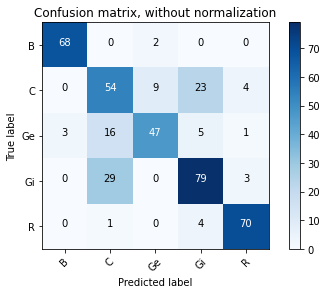

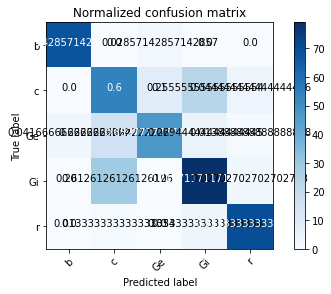

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##Lets make a confusing Confusion Matrix with SKLearn.
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pred = cylindricalModel.predict(X_test)
classes_pred = np.argmax(pred, axis = 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, classes_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
nonNormalMatrix = plot_confusion_matrix(cnf_matrix, classes=['B','C','Ge','Gi','R'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
normalMatrix = plot_confusion_matrix(cnf_matrix, classes=['b','c','Ge','Gi','r'], normalize=True, title='Normalized confusion matrix')
normalMatrix

In [ ]:
##We now print a classification report from confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        70
           1       0.54      0.60      0.57        90
           2       0.81      0.65      0.72        72
           3       0.71      0.71      0.71       111
           4       0.90      0.93      0.92        75

    accuracy                           0.76       418
   macro avg       0.78      0.77      0.78       418
weighted avg       0.77      0.76      0.76       418



<Figure size 432x288 with 0 Axes>

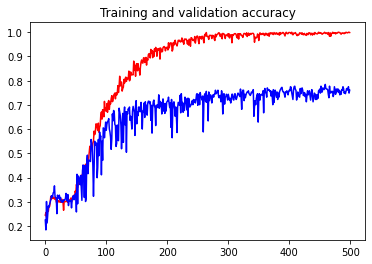

<Figure size 432x288 with 0 Axes>

In [ ]:
## Now we can do a little plot to see the correlation between the training statistics and the validation statistics. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt. plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()

Text(0, 0.5, 'Loss')

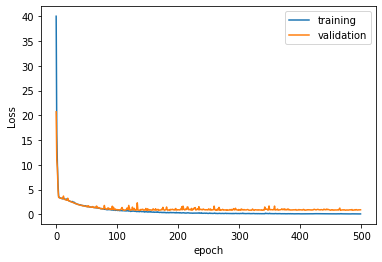

In [ ]:
# Plot the learning curves
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
cylindricalModel.save('/content/monomer-new-data/cylindrical-classified') 

Below we will run Keras without R values for cylindrical coordinates.

In [ ]:
#Clunky, but here we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/monomer-new-data/cylindrical-configs/b-config-cylindrical.csv', header=None)
cData = pd.read_csv('/content/monomer-new-data/cylindrical-configs/c-config-cylindrical.csv', header=None)
geData = pd.read_csv('/content/monomer-new-data/cylindrical-configs/ge-config-cylindrical.csv', header=None)
giData = pd.read_csv('/content/monomer-new-data/cylindrical-configs/gi-config-cylindrical.csv', header=None)

#Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/monomer-new-data/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/monomer-new-data/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/monomer-new-data/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/monomer-new-data/Answers/gi-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

##Using SKlearn for splitting test and training into 33% testing and the rest for training.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(totalData, totalAnswers, test_size=0.33, random_state=101)

## Here we initiate the keras sequential api and use dense layers. The final layer will output with softmax.
from keras.models import Sequential
from keras.layers import Dense
np.random.seed(1701)
cylindricalModelNoR = Sequential() 
cylindricalModelNoR.add(Dense(units =100, activation = 'relu', input_shape = totalData.shape[1:]))
cylindricalModelNoR.add(Dense(units = 50, activation='relu'))
classifier.add(Dropout(0.10))
cylindricalModelNoR.add(Dense(units = 5, activation = 'softmax', kernel_regularizer='l2'))

import math
epoch = 550
#initial_lrate = 1
#drop = 0.1
#epochs_drop = 60.0
#lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))

#opt = keras.optimizers.rmsprop(lr=lrate)

loss_fn = keras.losses.SparseCategoricalCrossentropy()

cylindricalModelNoR.compile(optimizer='rmsprop', loss =loss_fn, metrics=['accuracy'])

In [ ]:
 history = cylindricalModelNoR.fit(X_train, y_train, epochs=epoch,batch_size=30, validation_data=(X_test,y_test))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##Lets make a confusing Confusion Matrix with SKLearn.
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pred = cylindricalModelNoR.predict(X_test)
classes_pred = np.argmax(pred, axis = 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, classes_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
nonNormalMatrix = plot_confusion_matrix(cnf_matrix, classes=['B','C','Ge','Gi','R'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
normalMatrix = plot_confusion_matrix(cnf_matrix, classes=['b','c','Ge','Gi','r'], normalize=True, title='Normalized confusion matrix')
normalMatrix

In [ ]:
##We now print a classification report from confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_pred))

In [ ]:
## Now we can do a little plot to see the correlation between the training statistics and the validation statistics. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt. plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()

# 6. PCA for cylindrical coordinates

In [ ]:
##Now we attempt to consider the coordinates with 'centre of mass'.

#Clunky, but here we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/b-config-cylindrical.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/c-config-cylindrical.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/ge-config-cylindrical.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/gi-config-cylindrical.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])


## We need to scale this data accordingly.
#data = scale(totalData)
data = totalData

## We can now perform a PCA decomposition down to about 10 components.
pca = decomposition.PCA(n_components=10)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)
pcaCombinedDf

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000000
1,PC1,0.999433,0.999433
2,PC2,0.000206,0.999639
3,PC3,0.000062,0.999701
4,PC4,0.000053,0.999754
5,PC5,0.000043,0.999797
6,PC6,0.000023,0.999820
7,PC7,0.000013,0.999833
8,PC8,0.000012,0.999845
9,PC9,0.000010,0.999855


In [ ]:
scores = pca.transform(data)

## Put the scores into a readable dataframe. All the components will be shown.
scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])


##Lets append the labels on the PCA dataframe. $$$ B = 0 C = 1 Ge = 2 Gi = 3 $$$
df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df
scoresDataframe

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,labels
0,140.516579,56.597817,-0.151666,-0.539128,6.165660,-3.947851,-2.473086,7.540467,5.768806,-1.217223,0
1,846.856307,-15.793358,-0.584107,-0.582374,-41.706081,-7.896681,-4.405297,9.264864,-2.223046,-1.086955,0
2,1787.511998,-37.034162,-0.969029,1.430196,-12.374260,-16.195409,1.755585,5.859638,-10.631855,-4.177795,0
3,2164.462975,40.714618,-0.228309,-0.320462,-1.733928,-7.771427,-0.628521,4.660270,-8.242761,-0.661228,0
4,-156.427501,45.959611,-0.494684,-0.616392,3.107863,1.092332,8.099135,4.423607,5.334417,0.657947,0
...,...,...,...,...,...,...,...,...,...,...,...
1005,-336.067499,-0.285990,17.038698,-15.706367,-7.778554,-2.196438,-6.453620,-5.621639,-1.889858,4.612937,3
1006,-1802.307637,-10.293310,6.465151,-24.794721,2.508065,-0.146757,-0.175985,1.687109,-1.763465,-0.805513,3
1007,-1826.894481,8.328199,-25.645200,11.687553,-1.806238,1.177424,-0.682960,-4.006598,1.123058,4.999590,3
1008,-313.939548,-10.909649,19.881613,15.134807,-2.725686,-2.413496,-4.068946,-1.154855,1.520471,5.831426,3


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(scoresDataframe, x='PC1', y='PC2', color='labels')

fig.show()

# 7. Let us see about using MDS unsupervised learning

MDS for Radius of gyration coordinates set

Text(0.5, 1.0, 'Multidimensional Scaling (MDS); Radius of Gyration')

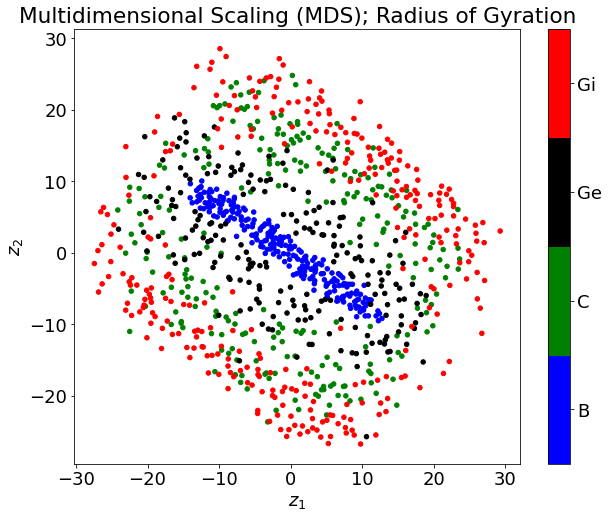

In [ ]:
bData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/b-config-gyration.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/c-config-gyration.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/ge-config-gyration.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/gi-config-gyration.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)
#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

# MDS (Raw data without subtracting center of mass)
# Scale the coordinates using standard scaler before the analysis

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(totalData)

from sklearn.manifold import MDS
mds = MDS(n_components=2, metric=True, n_init=10, max_iter=1000, eps=1e-4)
X_reduced = mds.fit_transform(X)

n_classes = 4
cmap = matplotlib.colors.ListedColormap(['blue', 'green', 'black', 'red'])

matplotlib.rcParams.update({'font.size':18})
plt.figure(figsize=(10,8))
sc = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=totalAnswers, s=20, cmap=cmap)
cbar = plt.colorbar(sc)

tick_locs = (np.arange(n_classes) + 0.5)*(n_classes-1)/n_classes
cbar.set_ticks(tick_locs)
# set tick labels (as before)
cbar.set_ticklabels(['B', 'C', 'Ge', 'Gi'])

plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Multidimensional Scaling (MDS); Radius of Gyration')

MDS for centre of mass

Text(0.5, 1.0, 'Multidimensional Scaling (MDS); centre of mass')

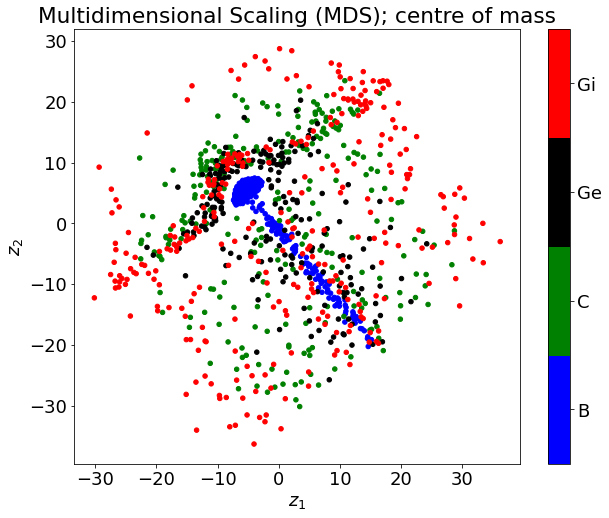

In [ ]:
bData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/b-config-centre.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/c-config-centre.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/ge-config-centre.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/centre-of-mass modified coordinates/gi-config-centre.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

# MDS (Raw data without subtracting center of mass)
# Scale the coordinates using standard scaler before the analysis

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(totalData)

from sklearn.manifold import MDS
mds = MDS(n_components=2, metric=True, n_init=10, max_iter=1000, eps=1e-4)
X_reduced = mds.fit_transform(X)

n_classes = 4
cmap = matplotlib.colors.ListedColormap(['blue', 'green', 'black', 'red'])

matplotlib.rcParams.update({'font.size':18})
plt.figure(figsize=(10,8))
sc = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=totalAnswers, s=20, cmap=cmap)
cbar = plt.colorbar(sc)

tick_locs = (np.arange(n_classes) + 0.5)*(n_classes-1)/n_classes
cbar.set_ticks(tick_locs)
# set tick labels (as before)
cbar.set_ticklabels(['B', 'C', 'Ge', 'Gi'])

plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Multidimensional Scaling (MDS); centre of mass')

MDS for cylindrical coordinates

Text(0.5, 1.0, 'Multidimensional Scaling (MDS); cylindrical coordinates')

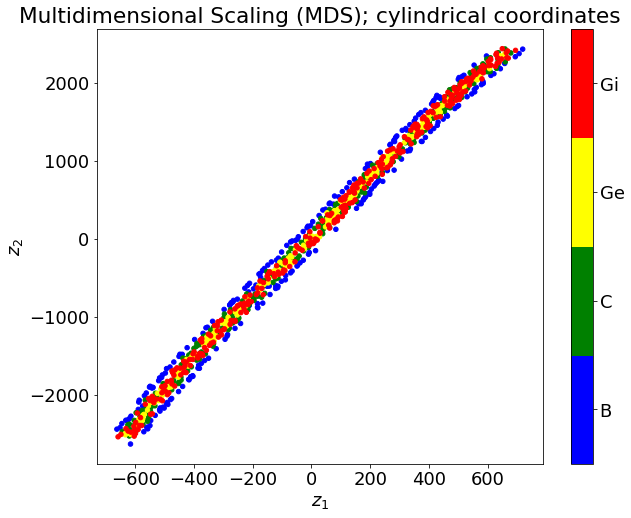

In [ ]:
#Clunky, but here we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/b-config-cylindrical.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/c-config-cylindrical.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/ge-config-cylindrical.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/cylindrical modified coordinates/gi-config-cylindrical.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

# MDS #

from sklearn.manifold import MDS
mds = MDS(n_components=2, metric=True, n_init=10, max_iter=1000, eps=1e-4)
X_reduced = mds.fit_transform(totalData)

n_classes = 4
cmap = matplotlib.colors.ListedColormap(['blue', 'green', 'yellow', 'red'])

matplotlib.rcParams.update({'font.size':18})
plt.figure(figsize=(10,8))
sc = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=totalAnswers, s=20, cmap=cmap)
cbar = plt.colorbar(sc)

tick_locs = (np.arange(n_classes) + 0.5)*(n_classes-1)/n_classes
cbar.set_ticks(tick_locs)
# set tick labels (as before)
cbar.set_ticklabels(['B', 'C', 'Ge', 'Gi'])

plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Multidimensional Scaling (MDS); cylindrical coordinates')

MDS for normal coordinates

Text(0.5, 1.0, 'Multidimensional Scaling (MDS)')

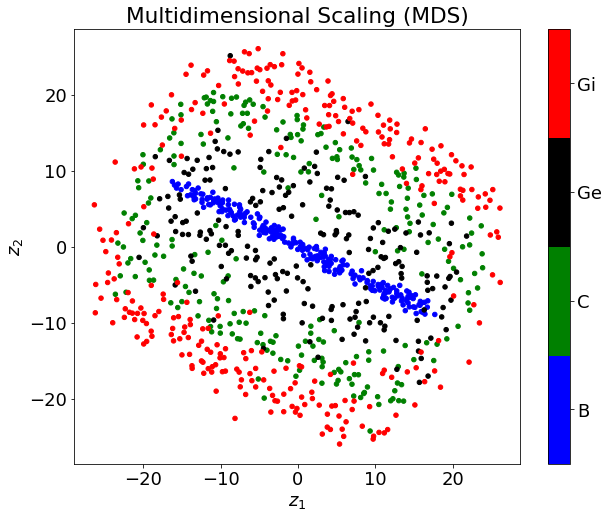

In [ ]:
##Clunky, but he we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/normal coordinates/b-config.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/normal coordinates/c-config.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/normal coordinates/ge-config.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/normal coordinates/gi-config.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

# MDS (Raw data without subtracting center of mass)
# Scale the coordinates using standard scaler before the analysis

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(totalData)

from sklearn.manifold import MDS
mds = MDS(n_components=2, metric=True, n_init=10, max_iter=1000, eps=1e-4)
X_reduced = mds.fit_transform(X)

n_classes = 4
cmap = matplotlib.colors.ListedColormap(['blue', 'green', 'black', 'red'])

matplotlib.rcParams.update({'font.size':18})
plt.figure(figsize=(10,8))
sc = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=totalAnswers, s=20, cmap=cmap)
cbar = plt.colorbar(sc)

tick_locs = (np.arange(n_classes) + 0.5)*(n_classes-1)/n_classes
cbar.set_ticks(tick_locs)
# set tick labels (as before)
cbar.set_ticklabels(['B', 'C', 'Ge', 'Gi'])

plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Multidimensional Scaling (MDS)')

In [ ]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=totalAnswers, s=5, cmap=cmap)

MDS for centre of mass modified coordinates converted to cylindrical coordinates.

Text(0.5, 1.0, 'Multidimensional Scaling (MDS); centre of mass and cylindrical')

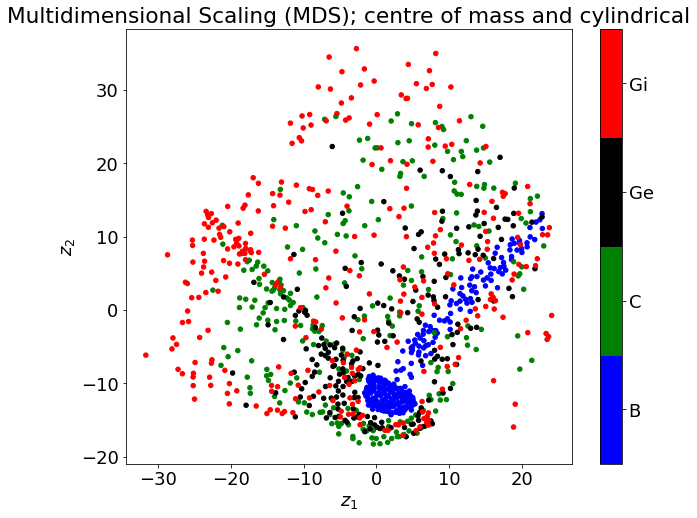

In [ ]:
bData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/b-config-centre-of-mass-cylindrical.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/c-config-centre-of-mass-cylindrical.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/ge-config-centre-of-mass-cylindrical.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/gi-config-centre-of-mass-cylindrical.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

# MDS (Raw data without subtracting center of mass)
# Scale the coordinates using standard scaler before the analysis

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(totalData)

from sklearn.manifold import MDS
mds = MDS(n_components=2, metric=True, n_init=10, max_iter=1000, eps=1e-4)
X_reduced = mds.fit_transform(X)

n_classes = 4
cmap = matplotlib.colors.ListedColormap(['blue', 'green', 'black', 'red'])

matplotlib.rcParams.update({'font.size':18})
plt.figure(figsize=(10,8))
sc = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=totalAnswers, s=20, cmap=cmap)
cbar = plt.colorbar(sc)

tick_locs = (np.arange(n_classes) + 0.5)*(n_classes-1)/n_classes
cbar.set_ticks(tick_locs)
# set tick labels (as before)
cbar.set_ticklabels(['B', 'C', 'Ge', 'Gi'])

plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Multidimensional Scaling (MDS); centre of mass and cylindrical')

MDS for centre of mass modified coordinates scaled by Radius of Gyration.

Text(0.5, 1.0, 'Multidimensional Scaling (MDS); centre of mass and radius of gyration')

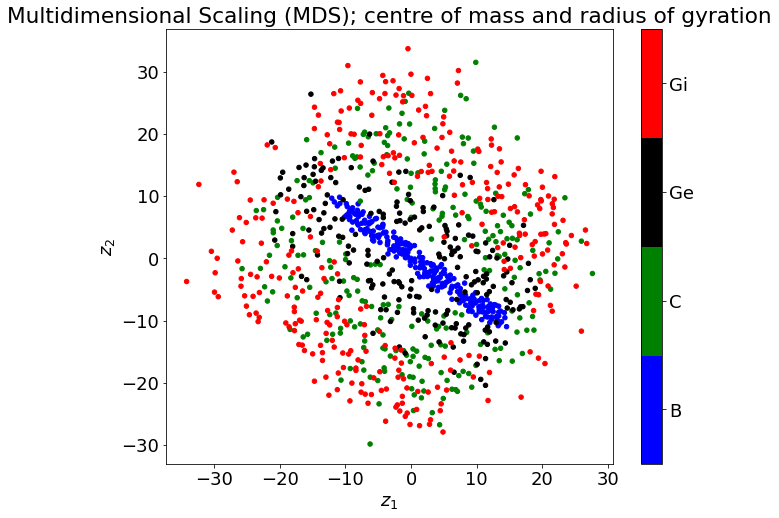

In [ ]:
bData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/b-config-centre-of-mass-ROG.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/c-config-centre-of-mass-ROG.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/ge-config-centre-of-mass-ROG.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/gi-config-centre-of-mass-ROG.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)

#Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

# MDS (Raw data without subtracting center of mass)
# Scale the coordinates using standard scaler before the analysis

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(totalData)

from sklearn.manifold import MDS
mds = MDS(n_components=2, metric=True, n_init=10, max_iter=1000, eps=1e-4)
X_reduced = mds.fit_transform(X)

n_classes = 4
cmap = matplotlib.colors.ListedColormap(['blue', 'green', 'black', 'red'])

matplotlib.rcParams.update({'font.size':18})
plt.figure(figsize=(10,8))
sc = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=totalAnswers, s=20, cmap=cmap)
cbar = plt.colorbar(sc)

tick_locs = (np.arange(n_classes) + 0.5)*(n_classes-1)/n_classes
cbar.set_ticks(tick_locs)
# set tick labels (as before)
cbar.set_ticklabels(['B', 'C', 'Ge', 'Gi'])

plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Multidimensional Scaling (MDS); centre of mass and radius of gyration')

# 8. Supervised learning on coordinates scaled with Radius of Gyration

In [8]:
##Clunky, but he we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/b-config-gyration.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/c-config-gyration.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/ge-config-gyration.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/gi-config-gyration.csv', header=None)
#rData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/r-config-gyration.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)
#rAnswers = pd.read_csv('/content/polymer-ML-research/Answers/r-labels.csv', header=None)
##Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

Notice the for loop


In [9]:
q = 1
for q in range(1):
  ##Using SKlearn for splitting test and training into 33% testing and the rest for training.
  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(totalData, totalAnswers, test_size=0.30)


  ## Here we initiate the keras sequential api and use dense layers.
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import Dropout
  np.random.seed(1701)
  classifierGyration = Sequential()
  classifierGyration.add(Dense(units =100, activation = 'relu', input_shape = totalData.shape[1:]))
  classifierGyration.add(Dense(units = 100, activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))) 
  classifierGyration.add(Dropout(0.20))
  classifierGyration.add(Dense(units = 5, activation = 'softmax', kernel_regularizer=keras.regularizers.l2(0.03)))

  from sklearn.preprocessing import StandardScaler

  #scaler = StandardScaler()
  #scaler.fit(X_train)

  #X_train = scaler.transform(X_train)
  #X_test = scaler.transform(X_test)


  #kernel_initializer='uniform'

  import math
  #initial_lrate = 1
  #drop = 0.1
  #epochs_drop = 60.0
  #lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  #opt = keras.optimizers.rmsprop(lr=lrate)
  classifierGyration.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.99, beta_2=0.99, epsilon=1e-07, name="Nadam"), loss =keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

  history = classifierGyration.fit(X_train, y_train, epochs=550,batch_size=30, validation_data=(X_test,y_test))

  q = q+1

Epoch 1/550
24/24 [==============================] - 0s 17ms/step - loss: 37.4673 - accuracy: 0.3706 - val_loss: 12.5686 - val_accuracy: 0.4092
Epoch 2/550
24/24 [==============================] - 0s 5ms/step - loss: 15.4390 - accuracy: 0.4965 - val_loss: 10.3203 - val_accuracy: 0.6733
Epoch 3/550
24/24 [==============================] - 0s 5ms/step - loss: 9.7886 - accuracy: 0.5488 - val_loss: 6.4379 - val_accuracy: 0.6931
Epoch 4/550
24/24 [==============================] - 0s 5ms/step - loss: 6.7457 - accuracy: 0.5870 - val_loss: 4.7733 - val_accuracy: 0.6337
Epoch 5/550
24/24 [==============================] - 0s 5ms/step - loss: 6.0167 - accuracy: 0.5743 - val_loss: 5.4570 - val_accuracy: 0.6106
Epoch 6/550
24/24 [==============================] - 0s 5ms/step - loss: 5.1680 - accuracy: 0.6195 - val_loss: 3.9365 - val_accuracy: 0.6502
Epoch 7/550
24/24 [==============================] - 0s 5ms/step - loss: 3.9473 - accuracy: 0.6124 - val_loss: 3.9771 - val_accuracy: 0.6865
Epoch 8/

In [ ]:
%reset

Confusion matrix, without normalization
[[64  0  1  0]
 [ 0 66  5 19]
 [ 1 14 40  3]
 [ 0  7  0 83]]
Normalized confusion matrix
[[0.98 0.   0.02 0.  ]
 [0.   0.73 0.06 0.21]
 [0.02 0.24 0.69 0.05]
 [0.   0.08 0.   0.92]]


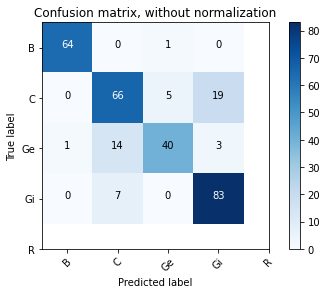

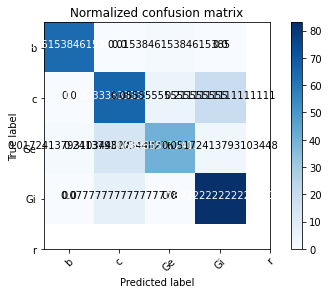

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##Lets make a confusing Confusion Matrix with SKLearn.
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pred = classifierGyration.predict(X_test)
classes_pred = np.argmax(pred, axis = 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, classes_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
nonNormalMatrix = plot_confusion_matrix(cnf_matrix, classes=['B','C','Ge','Gi','R'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
normalMatrix = plot_confusion_matrix(cnf_matrix, classes=['b','c','Ge','Gi','r'], normalize=True, title='Normalized confusion matrix')
normalMatrix

In [11]:
##We now print a classification report from confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        65
           1       0.76      0.73      0.75        90
           2       0.87      0.69      0.77        58
           3       0.79      0.92      0.85        90

    accuracy                           0.83       303
   macro avg       0.85      0.83      0.84       303
weighted avg       0.84      0.83      0.83       303



<Figure size 432x288 with 0 Axes>

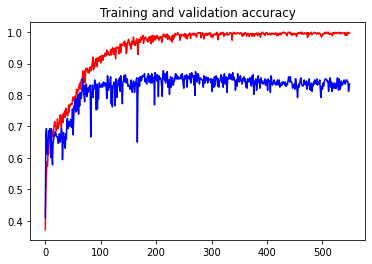

<Figure size 432x288 with 0 Axes>

In [12]:
## Now we can do a little plot to see the correlation between the training statistics and the validation statistics. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))



plt.plot(epochs, acc, 'r', label='Training accuracy')
plt. plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()




# 9. PCA with coordinates scaled with Radius of Gyration

In [ ]:
bData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/b-config-gyration.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/c-config-gyration.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/ge-config-gyration.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/gi-config-gyration.csv', header=None)
rData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/r-config-gyration.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)
rAnswers = pd.read_csv('/content/polymer-ML-research/Answers/r-labels.csv', header=None)


## We need to scale this data accordingly.
#data = scale(totalData)
data = totalData

In [ ]:
## We can now perform a PCA decomposition down to about 10 components.
pca = decomposition.PCA(n_components=10)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
scores = pca.transform(data)

## Put the scores into a readable dataframe. All the components will be shown.
scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])


##Lets append the labels on the PCA dataframe. $$$ B = 0 C = 1 Ge = 2 Gi = 3 $$$
df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df
scoresDataframe

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,labels
0,91.457972,9.787521,-5.714559,4.392644,2.215764,-0.360497,23.793966,3.978740,1.766479,2.123397,0
1,686.970475,-221.521102,-26.429674,-2.560828,-5.556457,1.183583,22.785171,-23.118522,3.628362,-5.507414,0
2,1418.985590,-517.938290,-45.528610,-9.269540,1.265366,0.426554,-10.954256,-20.816327,5.200373,-4.326892,0
3,1699.097198,-584.234505,-52.431818,-12.077723,-3.295970,0.961984,23.311938,-1.051504,0.774972,1.240927,0
4,-130.738782,101.170073,-0.285459,5.448208,-0.107154,-1.904993,23.260875,8.651599,-1.491699,1.121450,0
...,...,...,...,...,...,...,...,...,...,...,...
1261,1135.636486,-339.741690,-66.200235,-21.185063,-8.737077,4.160566,-31.889505,19.651182,3.836110,3.416024,4
1262,-1870.612928,526.769745,-12.448862,0.025093,15.257989,2.082036,-7.173748,7.995668,-15.062854,17.940238,4
1263,1043.450548,-66.632506,-24.927119,-5.980880,7.311044,14.302675,29.676818,-12.905712,16.803185,-5.212858,4
1264,-742.878392,-102.979598,-39.918260,-13.081399,18.245194,10.342404,26.561327,-6.339865,17.740951,-3.530301,4


In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)
pcaCombinedDf

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000000
1,PC1,0.905163,0.905163
2,PC2,0.044334,0.949497
3,PC3,0.028899,0.978396
4,PC4,0.019969,0.998365
5,PC5,0.000875,0.999240
6,PC6,0.000381,0.999621
7,PC7,0.000101,0.999722
8,PC8,0.000031,0.999753
9,PC9,0.000025,0.999778


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(scoresDataframe, x='PC1', y='PC2', color='labels')

fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(scoresDataframe, x='PC1', y='PC2', z='PC3', color='labels')

fig.show()

PCA with coordinates scaled Radius of Gyration without R

In [ ]:
##This data frame is concat from 100 row element files (127 files in total). Each monomer structure is created by 100 rows, each with three coordinates.

##Clunky, but he we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/b-config-gyration.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/c-config-gyration.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/ge-config-gyration.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/gyration modified coordinates/gi-config-gyration.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)

##Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

In [ ]:
## We need to scale this data accordingly.
#data = scale(totalData)
data = totalData

In [ ]:
## We can now perform a PCA decomposition down to about 10 components.
pca = decomposition.PCA(n_components=10)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
scores = pca.transform(data)

## Put the scores into a readable dataframe. All the components will be shown.
scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])


##Lets append the labels on the PCA dataframe. $$$ B = 0 C = 1 Ge = 2 Gi = 3 $$$
df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df
scoresDataframe

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,labels
0,113.049421,9.566235,0.414490,-1.269005,-23.920831,2.839466,-1.421422,-0.726603,-2.115587,4.577534,0
1,698.851296,-246.274002,2.943460,3.970608,-21.746211,-24.236705,5.706717,1.109367,-4.184971,-3.137424,0
2,1418.416288,-572.404050,1.025836,-1.070620,11.268412,-19.800427,0.861080,-4.266771,-6.534700,-6.011303,0
3,1695.653186,-650.131596,3.032053,2.560339,-23.947981,-1.608932,1.866617,-0.930647,-6.364798,2.907771,0
4,-105.306177,109.903769,0.022470,1.055562,-23.821147,7.289282,-0.304195,1.813953,5.158042,1.445248,0
...,...,...,...,...,...,...,...,...,...,...,...
1005,-419.226406,-110.492334,-18.571431,-28.708984,-5.918028,-4.626191,-0.229210,-5.192057,-4.568589,1.374336,3
1006,-1999.791839,-247.397336,-6.673947,-26.712694,7.030114,0.508561,6.308271,6.120793,-3.563169,2.856025,3
1007,-2072.301720,-301.160438,29.507639,10.252210,-5.566178,0.641812,-10.461461,-1.595495,1.241516,-5.359363,3
1008,-334.527391,-31.239482,-23.568091,21.945933,4.997379,-4.695832,6.141008,-1.838752,0.421476,-6.985412,3


In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)
pcaCombinedDf

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000000
1,PC1,0.957530,0.957530
2,PC2,0.041915,0.999445
3,PC3,0.000115,0.999560
4,PC4,0.000102,0.999662
5,PC5,0.000080,0.999742
6,PC6,0.000024,0.999766
7,PC7,0.000015,0.999781
8,PC8,0.000015,0.999796
9,PC9,0.000011,0.999807


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(scoresDataframe, x='PC1', y='PC2', color='labels')

fig.show()

# 10. Supervised learning on centre of mass standardized coordinates converted to cylindrical

In [ ]:
##This data frame is concat from 100 row element files (127 files in total). Each monomer structure is created by 100 rows, each with three coordinates.

##Clunky, but he we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/b-config-centre-of-mass-cylindrical.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/c-config-centre-of-mass-cylindrical.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/ge-config-centre-of-mass-cylindrical.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/gi-config-centre-of-mass-cylindrical.csv', header=None)
rData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/r-config-centre-of-mass-cylindrical.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)
rAnswers = pd.read_csv('/content/polymer-ML-research/Answers/r-labels.csv', header=None)

##Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData, rData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers, rAnswers])

##Using SKlearn for splitting test and training into 33% testing and the rest for training.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(totalData, totalAnswers, test_size=0.33, random_state=34234)

In [ ]:
#from sklearn.model_selection import StratifiedKFold
#seed = 1701
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
#cvscores = []
#for train, test in kfold.split(totalData, totalAnswers):


  ## Here we initiate the keras sequential api and use dense layers.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
np.random.seed(1701)
centreMassCylindricalModel = Sequential()
centreMassCylindricalModel.add(Dense(units =100, activation = 'relu', input_shape = totalData.shape[1:]))
centreMassCylindricalModel.add(Dense(units = 100, activation='relu', kernel_regularizer=keras.regularizers.l2(0.03)))
centreMassCylindricalModel.add(Dropout(0.20))
centreMassCylindricalModel.add(Dense(units = 5, activation = 'softmax', kernel_regularizer=keras.regularizers.l2(0.02)))
  #kernel_initializer='uniform'


centreMassCylindricalModel.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.99, beta_2=0.99, epsilon=1e-07, name="Nadam"), loss =keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

history = centreMassCylindricalModel.fit(X_train, y_train, epochs=500,batch_size=30, validation_data=(X_test,y_test))

In [ ]:
#In case you need to clear the previous action, easily.
%reset

Confusion matrix, without normalization
[[82  1  0  0  0]
 [ 2 44  9 24  7]
 [ 3 23 25 19  0]
 [ 3 23 12 59  5]
 [ 3 11  0  5 58]]
Normalized confusion matrix
[[0.99 0.01 0.   0.   0.  ]
 [0.02 0.51 0.1  0.28 0.08]
 [0.04 0.33 0.36 0.27 0.  ]
 [0.03 0.23 0.12 0.58 0.05]
 [0.04 0.14 0.   0.06 0.75]]


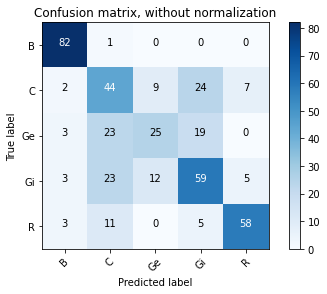

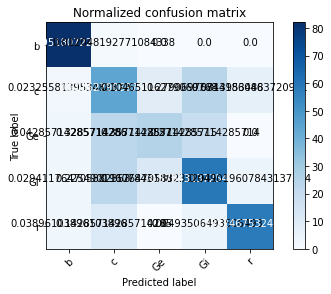

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##Lets make a confusing Confusion Matrix with SKLearn.
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pred = centreMassCylindricalModel.predict(X_test)
classes_pred = np.argmax(pred, axis = 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, classes_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
nonNormalMatrix = plot_confusion_matrix(cnf_matrix, classes=['B','C','Ge','Gi','R'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
normalMatrix = plot_confusion_matrix(cnf_matrix, classes=['b','c','Ge','Gi','r'], normalize=True, title='Normalized confusion matrix')
normalMatrix

In [ ]:
##We now print a classification report from confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93        83
           1       0.43      0.51      0.47        86
           2       0.54      0.36      0.43        70
           3       0.55      0.58      0.56       102
           4       0.83      0.75      0.79        77

    accuracy                           0.64       418
   macro avg       0.65      0.64      0.64       418
weighted avg       0.64      0.64      0.64       418



<Figure size 432x288 with 0 Axes>

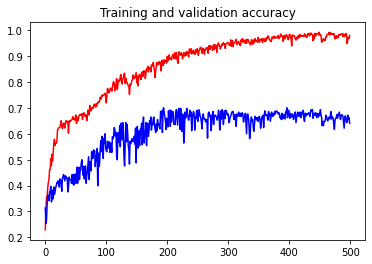

<Figure size 432x288 with 0 Axes>

In [ ]:
## Now we can do a little plot to see the correlation between the training statistics and the validation statistics. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))



plt.plot(epochs, acc, 'r', label='Training accuracy')
plt. plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
classifier.save('/content/monomer-new-data/myModel3') 

# 11. Unsupervised learning on centre of mass standardized coordinates converted to cylindrical

In [ ]:
## We need to scale this data accordingly.
#data = scale(totalData)
data = totalData

## We can now perform a PCA decomposition down to about 10 components.
pca = decomposition.PCA(n_components=10)
pca.fit(data)

scores = pca.transform(data)

## Put the scores into a readable dataframe. All the components will be shown.
scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])


##Lets append the labels on the PCA dataframe. $$$ B = 0 C = 1 Ge = 2 Gi = 3 $$$
df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df


explained_variance = pca.explained_variance_ratio_
explained_variance

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)
pcaCombinedDf

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000000
1,PC1,0.926753,0.926753
2,PC2,0.054317,0.981070
3,PC3,0.018210,0.999280
4,PC4,0.000307,0.999587
5,PC5,0.000182,0.999769
6,PC6,0.000044,0.999813
7,PC7,0.000021,0.999834
8,PC8,0.000019,0.999853
9,PC9,0.000017,0.999870


Lets plot this

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(scoresDataframe, x='PC1', y='PC2', color='labels')

fig.show()

We will do the same but now without R

In [ ]:
##Clunky, but he we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/b-config-centre-of-mass-cylindrical.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/c-config-centre-of-mass-cylindrical.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/ge-config-centre-of-mass-cylindrical.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-cylindrical/gi-config-centre-of-mass-cylindrical.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)

##Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

data = totalData

pca = decomposition.PCA(n_components=10)
pca.fit(data)

scores = pca.transform(data)

scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df

explained_variance = pca.explained_variance_ratio_

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(scoresDataframe, x='PC1', y='PC2', color='labels', title="PCA. This does not include the 'R' type, or scaling.")

fig.show()

# 12. Supervised learning on centre of mass standardized coordinates scaled with Radius of Gyration

In [2]:
##This data frame is concat from 100 row element files (127 files in total). Each monomer structure is created by 100 rows, each with three coordinates.

##Clunky, but he we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/b-config-centre-of-mass-ROG.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/c-config-centre-of-mass-ROG.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/ge-config-centre-of-mass-ROG.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/gi-config-centre-of-mass-ROG.csv', header=None)
rData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/r-config-centre-of-mass-ROG.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)
rAnswers = pd.read_csv('/content/polymer-ML-research/Answers/r-labels.csv', header=None)

##Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData, rData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers, rAnswers])

##Using SKlearn for splitting test and training into 33% testing and the rest for training.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(totalData, totalAnswers, test_size=0.33, random_state=34234)

In [3]:
#from sklearn.model_selection import StratifiedKFold
#seed = 1701
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
#cvscores = []
#for train, test in kfold.split(totalData, totalAnswers):


  ## Here we initiate the keras sequential api and use dense layers.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
np.random.seed(1701)
centreOfMassROGModel = Sequential()
centreOfMassROGModel.add(Dense(units =100, activation = 'relu', input_shape = totalData.shape[1:]))
centreOfMassROGModel.add(Dense(units = 100, activation='relu', kernel_regularizer=keras.regularizers.l2(0.03)))
centreOfMassROGModel.add(Dropout(0.20))
centreOfMassROGModel.add(Dense(units = 5, activation = 'softmax', kernel_regularizer=keras.regularizers.l2(0.02)))
  #kernel_initializer='uniform'

import math
  #initial_lrate = 1
  #drop = 0.1
  #epochs_drop = 60.0
  #lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  #opt = keras.optimizers.rmsprop(lr=lrate)
centreOfMassROGModel.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.99, beta_2=0.99, epsilon=1e-07, name="Nadam"), loss =keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

history = centreOfMassROGModel.fit(X_train, y_train, epochs=500,batch_size=30, validation_data=(X_test,y_test))

  #scores = model.evaluate(X_test, y_test, verbose=0)
 # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#cvscores.append(scores[1] * 100)
#print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/500
29/29 [==============================] - 0s 16ms/step - loss: 29.4282 - accuracy: 0.3078 - val_loss: 21.6678 - val_accuracy: 0.3541
Epoch 2/500
29/29 [==============================] - 0s 5ms/step - loss: 14.2259 - accuracy: 0.3550 - val_loss: 10.0412 - val_accuracy: 0.4306
Epoch 3/500
29/29 [==============================] - 0s 5ms/step - loss: 9.2835 - accuracy: 0.3844 - val_loss: 9.1252 - val_accuracy: 0.3589
Epoch 4/500
29/29 [==============================] - 0s 5ms/step - loss: 6.6378 - accuracy: 0.3585 - val_loss: 5.9664 - val_accuracy: 0.4713
Epoch 5/500
29/29 [==============================] - 0s 5ms/step - loss: 5.3939 - accuracy: 0.4057 - val_loss: 5.1564 - val_accuracy: 0.3182
Epoch 6/500
29/29 [==============================] - 0s 5ms/step - loss: 4.3645 - accuracy: 0.4021 - val_loss: 4.2133 - val_accuracy: 0.3923
Epoch 7/500
29/29 [==============================] - 0s 5ms/step - loss: 4.2737 - accuracy: 0.4104 - val_loss: 4.1053 - val_accuracy: 0.4163
Epoch 8/

In [6]:
#In case you need to clear the previous action, easily.
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Confusion matrix, without normalization
[[73  1  9  0  0]
 [ 0 55  7 14 10]
 [ 7 20 37  6  0]
 [ 0 11  0 83  8]
 [ 0  1  2  8 66]]
Normalized confusion matrix
[[0.88 0.01 0.11 0.   0.  ]
 [0.   0.64 0.08 0.16 0.12]
 [0.1  0.29 0.53 0.09 0.  ]
 [0.   0.11 0.   0.81 0.08]
 [0.   0.01 0.03 0.1  0.86]]


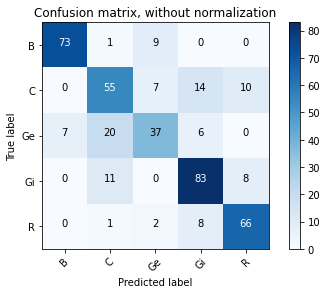

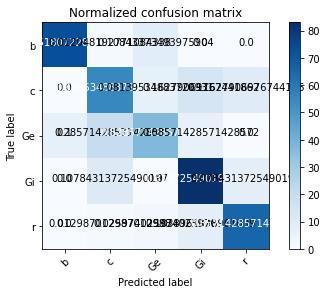

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##Lets make a confusing Confusion Matrix with SKLearn.
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

pred = centreOfMassROGModel.predict(X_test)
classes_pred = np.argmax(pred, axis = 1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, classes_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
nonNormalMatrix = plot_confusion_matrix(cnf_matrix, classes=['B','C','Ge','Gi','R'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
normalMatrix = plot_confusion_matrix(cnf_matrix, classes=['b','c','Ge','Gi','r'], normalize=True, title='Normalized confusion matrix')
normalMatrix

In [5]:
##We now print a classification report from confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, classes_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90        83
           1       0.62      0.64      0.63        86
           2       0.67      0.53      0.59        70
           3       0.75      0.81      0.78       102
           4       0.79      0.86      0.82        77

    accuracy                           0.75       418
   macro avg       0.75      0.74      0.74       418
weighted avg       0.75      0.75      0.75       418



<Figure size 432x288 with 0 Axes>

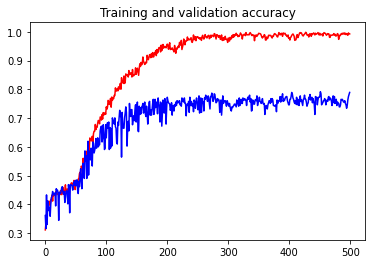

<Figure size 432x288 with 0 Axes>

In [ ]:
## Now we can do a little plot to see the correlation between the training statistics and the validation statistics. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))



plt.plot(epochs, acc, 'r', label='Training accuracy')
plt. plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()


In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
centreOfMassROGModel.save('/content/monomer-new-data/myModel3') 

NameError: ignored

# 13. Unsupervised learning with centre of mass standardized coordinates scaled with Radius of gyration

In [ ]:
## We need to scale this data accordingly.
#data = scale(totalData)
data = totalData

## We can now perform a PCA decomposition down to about 10 components.
pca = decomposition.PCA(n_components=10)
pca.fit(data)

scores = pca.transform(data)

## Put the scores into a readable dataframe. All the components will be shown.
scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])


##Lets append the labels on the PCA dataframe. $$$ B = 0 C = 1 Ge = 2 Gi = 3 $$$
df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df


explained_variance = pca.explained_variance_ratio_
explained_variance

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)
pcaCombinedDf

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000000
1,PC1,0.834516,0.834516
2,PC2,0.108117,0.942633
3,PC3,0.025532,0.968165
4,PC4,0.024232,0.992397
5,PC5,0.005592,0.997989
6,PC6,0.001687,0.999676
7,PC7,0.000086,0.999762
8,PC8,0.000026,0.999788
9,PC9,0.000021,0.999809


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(scoresDataframe, x='PC1', y='PC2', z='PC3', color='labels')

fig.show()

Now without R type

In [ ]:
##Clunky, but he we read each different type of monomer into a pandas df.
bData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/b-config-centre-of-mass-ROG.csv', header=None)
cData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/c-config-centre-of-mass-ROG.csv', header=None)
geData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/ge-config-centre-of-mass-ROG.csv', header=None)
giData = pd.read_csv('/content/polymer-ML-research/centre-of-mass-radius-of-gyration/gi-config-centre-of-mass-ROG.csv', header=None)

##Read in the "answers" for the monomer types. B = 0, C = 1, Ge = 2, Gi = 3 for our case
bAnswers = pd.read_csv('/content/polymer-ML-research/Answers/b-labels.csv', header = None)
cAnswers = pd.read_csv('/content/polymer-ML-research/Answers/c-labels.csv', header = None)
geAnswers = pd.read_csv('/content/polymer-ML-research/Answers/ge-labels.csv', header=None)
giAnswers = pd.read_csv('/content/polymer-ML-research/Answers/gi-labels.csv', header=None)

##Now we shall concat, respectivly, the Data & Answers
totalData = pd.concat([bData, cData, geData, giData])
totalAnswers = pd.concat([bAnswers, cAnswers, geAnswers, giAnswers])

data = totalData

pca = decomposition.PCA(n_components=10)
pca.fit(data)

scores = pca.transform(data)

scoresDataframe = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

df =totalAnswers
scoresDataframe = scoresDataframe.reset_index(drop=True)
df = df.reset_index(drop=True)

scoresDataframe.loc[:,'labels'] = df

explained_variance = pca.explained_variance_ratio_

explainedVariance = np.insert(explained_variance,0,0)
cumulativeVariance = np.cumsum(np.round(explainedVariance, decimals=6))

pcChart = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], columns=['PC'])
explainedVarianceDataframe = pd.DataFrame(explainedVariance, columns=['Explained Variance'])
cumulativeVarianceDataframe = pd.DataFrame(cumulativeVariance, columns=['Cumulative Variance'])

pcaCombinedDf = pd.concat([pcChart, explainedVarianceDataframe, cumulativeVarianceDataframe], axis=1)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

#This is the line graph
fig.add_trace(go.Scatter(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Cumulative Variance'], marker=dict(size=10, color="LightSeaGreen")), row=1, col=1)

#This is the bar graph
fig.add_trace(go.Bar(x=pcaCombinedDf['PC'], y=pcaCombinedDf['Explained Variance'],marker=dict(color="RoyalBlue"),), row=1, col=2)


fig.update_layout(
    title="PCA stats",
    xaxis_title="PCA number",
    yaxis_title="Percentage",
    font=dict(family="Times New Roman, monospace", size=11))
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(scoresDataframe, x='PC1', y='PC2', color='labels', title="PCA. This does not include the 'R' type.")

fig.show()